---
# <center> <font size="15"> <font color='red'>**SSH connect to get only useful SOLEDGE data on Marconi**</font></font>
---

---
## <center> <font color='xkcd:cherry red'>**Authentification**</font>
---

In [5]:
import paramiko
import h5py
from stat import S_ISDIR, S_ISREG
import numpy as np

# Get password
#password = getpass.getpass(prompt='Password: ', stream=None)
password = 'Theinetrobot4428!!'

# Create SSH client
ssh = paramiko.SSHClient()

## Add missing host key
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

## Connect to the server
def connect():
    try:
        ssh.connect(hostname='login.marconi.cineca.it', username='rvarenne', password=password)
    except:
        print('Connection failed. Please try again.')
        return False
    return True

## Print all file in remote directory
def print_all_files_in_remote_directory(directory):
    sftp = ssh.open_sftp()
    for entry in sftp.listdir_attr(directory):
        mode = entry.st_mode
        if S_ISDIR(mode):
            print(entry.filename + " is folder")
        elif S_ISREG(mode):
            print(entry.filename + " is file")

## Print all keys of hdf5 file in remote directory
def print_keys_of_hdf5_file_in_remote_directory(directory, filename):
    sftp = ssh.open_sftp()
    f = sftp.open(directory+'/'+filename, 'r')
    print(f)
    fh5 = h5py.File(f, 'r')
    print(fh5.keys())

## Print a numpy array of a specific dataset in hdf5 file in remote directory
def print_numpy_array_of_dataset_in_hdf5_file_in_remote_directory(directory, filename, dataset):
    sftp = ssh.open_sftp()
    f = sftp.open(directory+'/'+filename, 'r')
    fh5 = h5py.File(f, 'r')
    print( np.array( fh5.get(dataset) ) )

test_directory='/marconi_scratch/userexternal/rvarenne/SOLEDGE_TEST_CASE1/circular_noEIRENE_3D_gloria_version/run_dir'
test_filename='plasmaFinal.h5'
#test_filename='mesh_raptorX.h5'
test_dataset='zone1/ExB/psi'

if connect():
    print_all_files_in_remote_directory(test_directory)
    print_keys_of_hdf5_file_in_remote_directory(test_directory, test_filename)
    print_numpy_array_of_dataset_in_hdf5_file_in_remote_directory(test_directory, test_filename, test_dataset)
    #ssh.close()

mesh_raptorX.h5 is file
soledge3x is file
dVdS_raptorX.h5 is file
split_raptorX.h5 is file
metric_raptorX.h5 is file
timeInfo.txt is file
refParam_raptorX.h5 is file
balances_0 is file
sources_raptorX.h5 is file
masks_raptorX.h5 is file
param_raptorX.txt is file
species_raptorX.txt is file
balances_1 is file
param_geom.txt is file
plasmaFinal.h5 is file
Plasma is folder
soledge3x.status is file
<KeysViewHDF5 ['NZones', 'Nelts', 'Nspecies', 'core', 'dt', 'metadata', 'tExec', 'tExecCumu', 'tNextSave', 'tcpu', 'tcpuCumu', 'tsimu', 'zone1', 'zone2']>
[[[ 1.23511257e-05  1.24455159e-05  1.24972011e-05 ...  1.24455159e-05
    1.24972011e-05  1.23062044e-05]
  [ 5.35618430e-06  5.36020489e-06  5.46588756e-06 ...  5.36020489e-06
    5.46588756e-06  5.43286753e-06]
  [-3.98699492e-06 -4.08891471e-06 -4.03048851e-06 ... -4.08891471e-06
   -4.03048851e-06 -3.94567233e-06]
  ...
  [ 5.35618430e-06  5.36020489e-06  5.46588756e-06 ...  5.36020489e-06
    5.46588756e-06  5.43286753e-06]
  [-3.9869949

Socket exception: Une connexion existante a dû être fermée par l’hôte distant (10054)


---
## <center> <font color='xkcd:cherry red'>**Proof of concept : get $\langle \mathbf{E}\times\mathbf{B} \cdot \nabla \theta \rangle_{FS}$ and plot radial profile**</font>
---

Connection failed. Please try again.
None


ValueError: x, y, and format string must not be None

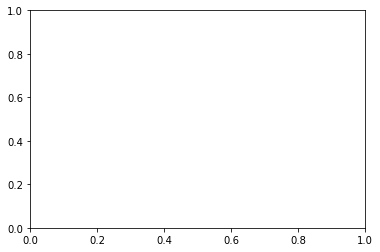

In [2]:
## Get the flux averaged value of a specific dataset in hdf5 file in remote directory
def get_FS_profile(directory, filename, dataset):
    sftp = ssh.open_sftp()
    f = sftp.open(directory+'/'+filename, 'r')
    fh5 = h5py.File(f, 'r')
    data = np.mean( np.array( fh5.get(dataset) ) , axis=(1,2))
    fh5.close()
    return data
    
    
#directory='/marconi_scratch/userexternal/rvarenne/SOLEDGE_TEST_CASE1/circular_noEIRENE_3D_gloria_version/run_dir'
directory='/marconi_scratch/userexternal/gfalchet/S3XE/SE3Xneo/3Dneo_from52thVQ/neo3D_r13/run_dir'
filename='plasmaFinal.h5'
dataset='zone1/ExB/theta'

data = None
if connect():
    data = get_FS_profile(directory, filename, dataset)
    ssh.close()

print(data)

import matplotlib.pyplot as plt
plt.plot(data)
plt.axhline(y=0, color='k', linestyle='--')


---
## <center> <font color='xkcd:cherry red'>**Construct the time averaged $\langle \mathbf{E}\times\mathbf{B} \cdot \nabla \theta \rangle_{FS}$**</font>
---

In [10]:
from joblib import Parallel, delayed
import dill as pickle

## Open a SFTP connection
sftp = ssh.open_sftp()

directory='/marconi_scratch/userexternal/gfalchet/S3XE/SE3Xneo/3Dneo_from52thVQ/neo3D_r13/run_dir/Plasma'

## Get the list of filepath of Plasma_xxx.h5
filename_ar=sorted(sftp.listdir(directory))
print(filename_ar)

## Create a filepath array by adding the directory path to the filename for each element of filename_ar
filepath_ar = [directory+'/'+filename for filename in filename_ar]

i = 1
## Define a function that takes a file path (to the Plasma_xxx.h5) as an input and return the flux surface averaged value of ExB.e_theta
def get_FS_profile(filepath):
    global i
    print('Iteration %s / %s' % (i, len(filepath_ar)))
    i += 1
    # print('In the function !')
    f = sftp.open(filepath, 'r')
    # print('Passed the sftp thingy !')
    fh5 = h5py.File(f, 'r')
    # print('fh5 is opened !')
    data = np.mean( np.array( fh5.get('zone1/ExB/theta') ) , axis=(1,2))
    # print('Big calculation done !')
    fh5.close()
    # print('No it is not crashed !')
    return data


## Map the get_FS_profile function to the filepath_ar array
if connect():
    Er_time_trace = list(map(get_FS_profile, filepath_ar[:25]))

    #Er_time_trace = Parallel(n_jobs=6, prefer="threads")(delayed(get_FS_profile)(x) for x in filepath_ar[:5])

np.save('Er_time_trace.npy', Er_time_trace)

['plasma_00000.h5', 'plasma_00001.h5', 'plasma_00002.h5', 'plasma_00003.h5', 'plasma_00004.h5', 'plasma_00005.h5', 'plasma_00006.h5', 'plasma_00007.h5', 'plasma_00008.h5', 'plasma_00009.h5', 'plasma_00010.h5', 'plasma_00011.h5', 'plasma_00012.h5', 'plasma_00013.h5', 'plasma_00014.h5', 'plasma_00015.h5', 'plasma_00016.h5', 'plasma_00017.h5', 'plasma_00018.h5', 'plasma_00019.h5', 'plasma_00020.h5', 'plasma_00021.h5', 'plasma_00022.h5', 'plasma_00023.h5', 'plasma_00024.h5', 'plasma_00025.h5', 'plasma_00026.h5', 'plasma_00027.h5', 'plasma_00028.h5', 'plasma_00029.h5', 'plasma_00030.h5', 'plasma_00031.h5', 'plasma_00032.h5', 'plasma_00033.h5', 'plasma_00034.h5', 'plasma_00035.h5', 'plasma_00036.h5', 'plasma_00037.h5', 'plasma_00038.h5', 'plasma_00039.h5', 'plasma_00040.h5', 'plasma_00041.h5', 'plasma_00042.h5', 'plasma_00043.h5', 'plasma_00044.h5', 'plasma_00045.h5', 'plasma_00046.h5', 'plasma_00047.h5', 'plasma_00048.h5', 'plasma_00049.h5', 'plasma_00050.h5', 'plasma_00051.h5', 'plasma_000

---
## <center> <font color='xkcd:cherry red'>**Visualize the time averaged $\langle \mathbf{E}\times\mathbf{B} \cdot \nabla \theta \rangle_{FS}$**</font>
---

In [17]:
import ipywidgets as widgets
%matplotlib widget
import matplotlib.pyplot as plt

from cycler import cycler
from matplotlib.colors import Normalize

# Change color cycler to have color gradient based on existing colormap
cmap = plt.cm.inferno
norm = Normalize(vmin=0, vmax=10)
colors = [cmap(norm(value)) for value in range(10)]
plt.rc('axes', prop_cycle=(cycler('color', colors)))

## Load ExB.e_theta time trace
Er = np.load('Er_time_trace.npy')

## Define radial coordinate array (temp)
rho_ar = np.linspace(0.7,1,Er.shape[1])

print(Er.shape)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.set_xlabel(r'$r/a$')

for i in range(Er.shape[0]):
    ax.plot(rho_ar,Er[i,:], lw=1.5)

ax.plot(rho_ar,np.mean(Er, axis=0), lw=3, color='r')

ax.grid()
ax.axhline(y=0, color='k', linestyle='--')

ax.set_title(r'Radial profile of $V_{E\times B}$ (black: initial, yellow: final)')


(25, 64)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Radial profile of $V_{E\\times B}$ (black: initial, yellow: final)')

In [78]:
## Mini test of parallelisation
from multiprocess import Pool
import numpy as np

def f(x):
    import numpy as np
    return np.array([x, x**2])

p = Pool(5)
t=p.map(f, np.arange(10))
print(t)


[array([0, 0]), array([1, 1]), array([2, 4]), array([3, 9]), array([ 4, 16]), array([ 5, 25]), array([ 6, 36]), array([ 7, 49]), array([ 8, 64]), array([ 9, 81])]


In [2]:
from joblib import Parallel, delayed

def f(x):
    return x + 2

numbers1 = Parallel(n_jobs=2, prefer="threads")(delayed(f)(x) for x in range(10))

print(numbers1)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
